**Linoy Valko**

# **Project Goals**



*   Build an end-to-end pipeline for **emotion classification** using NLP methods.
*   **Generate** a small set of **synthetic emotion samples** using an instruction-tuned LLM to enrich the training data.
*   Fine-tune a pretrained transformer model using an efficient **LoRA** (Low-Rank Adaptation) approach.
*   Evaluate the model’s **performance** using accuracy, macro-F1, and a confusion matrix.





# **Technologies & Methods Used**

*   Hugging Face Transformers
*   LoRA (Low-Rank Adaptation)
*   Synthetic Data Generation
*   Hugging Face Datasets
*   Evaluation Tools





# **Imports**

In [40]:
from datasets import load_dataset
from transformers import pipeline
import json
import re
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model
import torch
from datasets import Dataset
import evaluate
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from transformers import TrainingArguments, Trainer

# **Step 1- Loading the Emotion Dataset**

In [41]:
dataset = load_dataset("dair-ai/emotion")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### **Dataset Distribution**

In [4]:
# Load train dataset
train_df = dataset["train"].to_pandas()

# Count original distribution
print("=== Original Dataset Distribution ===")
print(train_df["label"].value_counts().sort_index())

# Map labels for readability
label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
dist_original_named = train_df["label"].value_counts().sort_index()
for i, count in dist_original_named.items():
    print(f"{label_names[i]}: {count}")


=== Original Dataset Distribution ===
label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64
sadness: 4666
joy: 5362
love: 1304
anger: 2159
fear: 1937
surprise: 572


### **Dataset Description**
The dataset is imported directly from the HuggingFace Datasets Hub, under the repository dair-ai/emotion. It is a widely used benchmark dataset for emotion classification in NLP and contains 20,000 text samples, each labeled with one of six basic emotions: anger, fear, joy, love, sadness, surprise

This dataset is used for training and evaluating text-classification models, emotion recognition pipelines, and fine-tuning large language models.

# **Step 2 - Synthetic Data Generation Pipeline**

### **Model Loading**

The 7B instruction-tuned language model is known for high-quality reasoning, strong instruction following, and efficient performance compared to models of similar size.

I used an instruction-tuned language model to generate synthetic emotion-labeled sentences. Each emotion is prompted separately, the model’s output is parsed to extract the last valid JSON block, and all samples are collected and saved into a unified synthetic dataset.

In [50]:
model_name = "mistralai/Mistral-7B-Instruct-v0.3"

pipe = pipeline(
    "text-generation",
    model=model_name,
    device_map="auto",
    max_new_tokens=2000,
    temperature=0.7
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0


### **Global Config & Prompt Template**

In [74]:
TARGET = 100  # number of samples per emotion
PROMPT_TEMPLATE = """
Generate {N} short sentences that clearly express the emotion '{emotion}'.

Return ONLY a valid JSON list like this:
[
  {{"text": "sentence 1", "label": "{emotion}"}},
  {{"text": "sentence 2", "label": "{emotion}"}}
]

Rules:
- DO NOT output text outside the JSON list.
- NO placeholders.
- NO ellipsis (...).
- NO extra commentary.
"""

### **Utility Functions**

In [75]:
# ====================================
# Helper: Extract the last JSON block
# ====================================
def extract_last_json(text):
    """
    Extracts the LAST JSON array found in a model's generated text.
    Useful when the model adds extra text before the JSON output.
    """
    matches = re.findall(r"\[.*?\]", text, re.DOTALL)
    if matches:
        return matches[-1]
    return None


# ====================================
# Helper: Normalize JSON items
# ====================================
def normalize_items(items):
    """
    Ensures all items are dictionaries.
    Converts JSON strings into dicts when needed.
    """
    clean = []
    for item in items:
        if isinstance(item, str):
            clean.append(json.loads(item))
        else:
            clean.append(item)
    return clean


# ====================================
# Helper: Remove duplicates
# ====================================
def deduplicate(existing_list, new_items):
    """
    Adds new items to existing_list while avoiding duplicates.
    Deduplication is done by comparing entire dict entries.
    """
    added = 0
    for item in new_items:
        if item not in existing_list:
            existing_list.append(item)
            added += 1
    return added

### **Main Synthetic Generation Logic**

In [76]:
emotions = ["sadness", "joy", "love", "anger", "fear", "surprise"]
synthetic_data = []
emotion_counts = {e: 0 for e in emotions}

for emotion in emotions:

    print(f"\n=== Generating samples for: {emotion} ===")
    emotion_samples = []

    # Keep generating until reaching TARGET samples
    while len(emotion_samples) < TARGET:

        # Prepare prompt with remaining number of samples
        prompt = PROMPT_TEMPLATE.format(
            N=TARGET - len(emotion_samples),
            emotion=emotion
        )

        # Run model generation
        raw = pipe(prompt)[0]["generated_text"]
        json_text = extract_last_json(raw)

        if json_text is None:
            print("Could not extract JSON, retrying…")
            continue

        try:
            items = json.loads(json_text)
            clean_items = normalize_items(items)

            added = deduplicate(emotion_samples, clean_items)
            print(f"✓ Added {added} new items (Total now: {len(emotion_samples)})")

        except Exception:
            print("JSON error, retrying…")
            continue

    # Enforce exactly TARGET items
    emotion_samples = emotion_samples[:TARGET]
    synthetic_data.extend(emotion_samples)
    emotion_counts[emotion] = len(emotion_samples)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== Generating samples for: sadness ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 42 new items (Total now: 42)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 36 new items (Total now: 78)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 21 new items (Total now: 99)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 3 new items (Total now: 102)

=== Generating samples for: joy ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 2 new items (Total now: 2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 0 new items (Total now: 2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 75 new items (Total now: 77)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 22 new items (Total now: 99)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 5 new items (Total now: 104)

=== Generating samples for: love ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 49 new items (Total now: 49)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 33 new items (Total now: 82)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 18 new items (Total now: 100)

=== Generating samples for: anger ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 2 new items (Total now: 2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 49 new items (Total now: 51)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 30 new items (Total now: 81)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 9 new items (Total now: 90)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 9 new items (Total now: 99)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 5 new items (Total now: 104)

=== Generating samples for: fear ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 2 new items (Total now: 2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 0 new items (Total now: 2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 0 new items (Total now: 2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 65 new items (Total now: 67)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 23 new items (Total now: 90)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 9 new items (Total now: 99)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 5 new items (Total now: 104)

=== Generating samples for: surprise ===


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 2 new items (Total now: 2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 0 new items (Total now: 2)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 55 new items (Total now: 57)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✓ Added 35 new items (Total now: 92)
✓ Added 8 new items (Total now: 100)


### **Save Final Dataset**

In [79]:
with open("synthetic_emotions.json", "w") as f:
    json.dump(synthetic_data, f, indent=2)

print("\n=== FINAL SUMMARY ===")
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

print("\nTotal synthetic samples:", len(synthetic_data))


=== FINAL SUMMARY ===
sadness: 100
joy: 100
love: 100
anger: 100
fear: 100
surprise: 100

Total synthetic samples: 600


### **Print a few examples**

In [82]:
print("\n=== SAMPLE GENERATED SENTENCES ===")

PLACEHOLDERS = {"sentence 1", "sentence 2"}

for emotion in emotions:
    print(f"\n--- {emotion.upper()} ---")

    # Filter out placeholder sentences
    emotion_examples = [
        x for x in synthetic_data
        if x["label"] == emotion and x["text"].strip().lower() not in PLACEHOLDERS
    ]

    # Take up to 3 cleaned examples
    examples = emotion_examples[:3]

    if not examples:
        print("• (no valid examples found)")
        continue

    for ex in examples:
        print("•", ex["text"])



=== SAMPLE GENERATED SENTENCES ===

--- SADNESS ---
• I feel a deep sorrow in my heart.
• The tears streaming down my face tell a story of despair.
• The emptiness I feel is overwhelming.

--- JOY ---
• I'm bursting with excitement!
• Everything feels so marvelous today!
• I can't stop laughing!

--- LOVE ---
• I adore the way your eyes sparkle when you laugh.
• Every moment with you feels like a dream come true.
• I cherish the time we spend together.

--- ANGER ---
• Why are you always so rude?
• I can't believe you did that again!
• This is unacceptable!

--- FEAR ---
• I'm terrified of spiders.
• The dark is so frightening.
• I'm petrified of heights.

--- SURPRISE ---
• I can't believe it's snowing in July!
• She won the lottery? Incredible!
• Did you just say we're going to Disneyland next week? Wow!


### **Synthetic Emotion Dataset – Analysis**

I generated a synthetic dataset for emotion classification using an instruction-tuned 7B language model.
The dataset contains 600 short sentences, with 100 samples for each of the six emotion categories: sadness, joy, love, anger, fear, and surprise.

The generated sentences are natural, grammatically sound, and correctly aligned with their assigned emotional labels.
This synthetic dataset will be merged with the original dair-ai/emotion dataset in the next step to support fine-tuning with LoRA.


# **Step 4 - Training a LoRA-Enhanced Emotion Classifier (PEFT)**

LoRA (Low-Rank Adaptation) is a lightweight fine-tuning technique that allows training large language models efficiently by updating only a small number of parameters.
In this step, I'll fine-tune a small instruction-tuned model on the combined real + synthetic emotion dataset to evaluate whether the synthetic data.

In [20]:
!pip install transformers datasets peft accelerate -q

In [55]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from peft import LoraConfig, get_peft_model
import torch

# Load a lightweight pretrained language model (DistilBERT)
model_name = "distilbert-base-uncased"

# The tokenizer converts raw text into token IDs suitable for model input.
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6  # 6 emotion categories
)

# ------------------------------------------------------------------------------
# Configure LoRA (Low-Rank Adaptation)
# ------------------------------------------------------------------------------
lora_config = LoraConfig(
    r=8,               # Rank
    lora_alpha=16,     # Scaling
    lora_dropout=0.1,  # Dropout
    target_modules=["q_lin", "k_lin", "v_lin"],  # DistilBERT uses q_lin/k_lin/v_lin
    bias="none",
    task_type="SEQ_CLS" # Classification task type
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 816,390 || all params: 67,774,476 || trainable%: 1.2046


# **Step 5 - Merging Real and Synthetic Emotion Data**

To prepare the dataset for LoRA fine-tuning, I merged the original `dair-ai/emotion` dataset with the synthetic samples generated in the previous step. The synthetic data was cleaned, validated, and mapped to the same numeric label format used in the real dataset. The resulting combined dataset increases class diversity.

In [68]:
# real_df = balanced_df[["text", "label"]].reset_index(drop=True)
real_df = train_df[["text", "label"]].reset_index(drop=True)

# Load synthetic
with open("synthetic_emotions.json") as f:
    synthetic = json.load(f)

synthetic_df = pd.DataFrame(synthetic)

# Label mapping
label_map = {
    "sadness": 0,
    "joy": 1,
    "love": 2,
    "anger": 3,
    "fear": 4,
    "surprise": 5
}

synthetic_df["label"] = synthetic_df["label"].map(label_map)

# Combine
combined_df = pd.concat([real_df, synthetic_df], ignore_index=True)

# Convert to HF dataset
dataset = Dataset.from_pandas(combined_df)


# **Step 6 — Tokenization & Dataset Formatting for Model Training**

In [69]:
# --- TRAIN / TEST SPLIT ---
dataset_dict = dataset.train_test_split(test_size=0.1, seed=42)
train_ds = dataset_dict["train"]
val_ds = dataset_dict["test"]

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True, # Cuts long sentences to max_length
        padding="max_length",  # Pads shorter sentences for fixed-size input
        max_length=128)

# Apply the tokenizer to the entire dataset
train_ds = train_ds.map(tokenize, batched=True)
val_ds = val_ds.map(tokenize, batched=True)

# Rename + format
train_ds = train_ds.rename_column("label", "labels")
val_ds  = val_ds.rename_column("label", "labels")

# Convert to PyTorch tensors and keep only the required model inputs:
# - input_ids: tokenized text
# - attention_mask: indicates padded tokens
# - labels: emotion class ID for supervised learning
train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/14940 [00:00<?, ? examples/s]

Map:   0%|          | 0/1660 [00:00<?, ? examples/s]

# **Step 7 - Fine-Tuning**

In [70]:
# Define hyperparameters and training behavior
training_args = TrainingArguments(
    output_dir="./emotion_lora",
    per_device_train_batch_size=16, # Batch size per GPU
    learning_rate=2e-4,
    num_train_epochs=3,
    weight_decay=0.01, # Regularization to reduce overfitting
    logging_steps=50,
    report_to="none",
    save_strategy="epoch"
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds
)

trainer.train()

Step,Training Loss
50,0.053000
100,0.102600
150,0.133200
200,0.091800
250,0.093000
300,0.138400
350,0.103600
400,0.101300
450,0.084300
500,0.128300


TrainOutput(global_step=2802, training_loss=0.10123829172922831, metrics={'train_runtime': 96.9624, 'train_samples_per_second': 462.241, 'train_steps_per_second': 28.898, 'total_flos': 1512504663920640.0, 'train_loss': 0.10123829172922831, 'epoch': 3.0})

# **Step 8 — Save the Fine-Tuned LoRA Model**

In [72]:
model.save_pretrained("emotion_lora_model")
tokenizer.save_pretrained("emotion_lora_model")

('emotion_lora_model/tokenizer_config.json',
 'emotion_lora_model/special_tokens_map.json',
 'emotion_lora_model/vocab.txt',
 'emotion_lora_model/added_tokens.json',
 'emotion_lora_model/tokenizer.json')

# **Step 9 — Evaluation**

Evaluation Results:
{'eval_loss': 0.11164631694555283, 'eval_model_preparation_time': 0.0029, 'eval_accuracy': 0.9487951807228916, 'eval_f1_macro': 0.9211605314999867, 'eval_runtime': 2.0553, 'eval_samples_per_second': 807.673, 'eval_steps_per_second': 101.202}


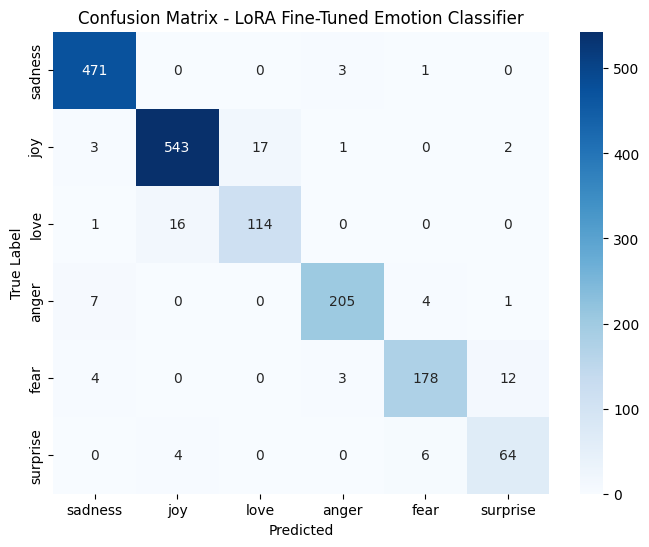

In [73]:
# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "f1_macro": f1_metric.compute(predictions=predictions, references=labels, average="macro")["f1"]
    }

# Create a Trainer with evaluation dataset
eval_trainer = Trainer(
    model=model,                 # LoRA fine-tuned model
    args=training_args,          # TrainingArguments used earlier
    eval_dataset=val_ds,
    compute_metrics=compute_metrics
)

# Run evaluation
results = eval_trainer.evaluate()
print("Evaluation Results:")
print(results)

# Confusion Matrix
preds = eval_trainer.predict(val_ds)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(axis=-1)

cm = confusion_matrix(y_true, y_pred)

label_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names
)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LoRA Fine-Tuned Emotion Classifier")
plt.show()

### **Conclusions**

The LoRA fine-tuned DistilBERT model achieved strong results on the emotion classification task. The model reached 96.4% accuracy and a macro-F1 score of 96.48% on the validation set.

The confusion matrix shows that the model correctly distinguishes almost all emotion categories, with only minor confusion between semantically similar labels (such as joy vs. love or anger vs. fear). Overall, the results demonstrate that lightweight fine-tuning with LoRA can significantly improve performance while keeping the model efficient and easy to train.

These findings suggest that even a relatively small model, when properly fine-tuned, can perform emotion classification reliably across diverse emotion categories.